# Download and save the standard deviation of FLSE on a 1x1 degree grid 

### Imports

In [9]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# statistics
import scipy as sci

# regridding package
import xesmf as xe

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
downloaddir="/scratch/es60/pjb581/AVISO/"

os.chdir(downloaddir)
os.getcwd()

from dask.diagnostics import ProgressBar
ProgressBar().register()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.0
matplotlib version = 3.10.0
cmocean version = v3.0.3


### Load the data

In [10]:
year = 2012
ds = xr.open_mfdataset(
    './%s/dt_global_allsat_madt_fsle_%s*.nc'%(year,year),
    combine='by_coords',
    parallel=True,
    chunks={'time': 1}
)
ds

[########################################] | 100% Completed | 25.66 s
[########################################] | 100% Completed | 25.74 s


<xarray.Dataset> Size: 119GB
Dimensions:    (time: 366, lat: 4500, nv: 2, lon: 9000)
Coordinates:
  * nv         (nv) int32 8B 0 1
  * time       (time) datetime64[ns] 3kB 2012-01-01 2012-01-02 ... 2012-12-31
  * lat        (lat) float32 18kB -89.98 -89.94 -89.9 ... 89.9 89.94 89.98
  * lon        (lon) float32 36kB 0.02 0.06 0.1 0.14 ... 359.9 359.9 359.9 360.0
Data variables:
    crs        (time) int32 1kB -2147483647 -2147483647 ... -2147483647
    lat_bnds   (time, lat, nv) float32 13MB dask.array<chunksize=(1, 4500, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 26MB dask.array<chunksize=(1, 9000, 2), meta=np.ndarray>
    fsle_max   (time, lat, lon) float32 59GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    theta_max  (time, lat, lon) float32 59GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/26)
    cdm_data_type:              Grid
    Conventions:                CF-1.6
    standard_name_vocabulary:   http://cf-pcmdi.llnl.gov/documents/cf-standar...
    title:                      Backward-in-time, finite-size Lyapunov expone...
    summary:                    This dataset contains Backward-in-time FSLE p...
    separation:                 Initial separation in degrees: 0.02; Maximal ...
    ...                         ...
    product_version:            1.0
    project:                    SSALTO/DUACS
    references:                 www.aviso.altimetry.fr
    end_time:                   2011-06-15 00:00:00
    start_time:                 2012-01-01 00:00:00
    time_coverage_resolution:   P4D

In [ ]:
%%time

ds = ds.compute()


[                                        ] | 2% Completed | 78.30 sms

### bin the data into 1x1 degree bins

In [4]:
%%time

# Create bin edges: from -179.5 to 180.5 by 1°
lon_bins = np.arange(0, 361, 1)
lat_bins = np.arange(-90, 91, 1)

# Use pandas.cut on the 1D coordinate arrays
lon_labels = lon_bins[:-1] + 0.5
lat_labels = lat_bins[:-1] + 0.5

# Apply binning to lon and lat values
lon_binned = pd.cut(ds['lon'].values, bins=lon_bins, labels=lon_labels)
lat_binned = pd.cut(ds['lat'].values, bins=lat_bins, labels=lat_labels)

# Create new coordinates
ds = ds.assign_coords(
    lon_bin=xr.DataArray(lon_binned, coords={"lon": ds['lon']}, dims="lon"),
    lat_bin=xr.DataArray(lat_binned, coords={"lat": ds['lat']}, dims="lat")
)

ds

CPU times: user 9.37 ms, sys: 28.6 ms, total: 38 ms
Wall time: 1.12 s


<xarray.Dataset> Size: 118GB
Dimensions:    (time: 365, lat: 4500, nv: 2, lon: 9000)
Coordinates:
  * nv         (nv) int32 8B 0 1
  * time       (time) datetime64[ns] 3kB 2011-01-01 2011-01-02 ... 2011-12-31
  * lat        (lat) float32 18kB -89.98 -89.94 -89.9 ... 89.9 89.94 89.98
  * lon        (lon) float32 36kB 0.02 0.06 0.1 0.14 ... 359.9 359.9 359.9 360.0
    lon_bin    (lon) category 21kB <class 'xarray.core.extension_array.Pandas...
    lat_bin    (lat) category 10kB <class 'xarray.core.extension_array.Pandas...
Data variables:
    crs        (time) int32 1kB -2147483647 -2147483647 ... -2147483647
    lat_bnds   (time, lat, nv) float32 13MB -90.0 -89.96 -89.96 ... 89.96 90.0
    lon_bnds   (time, lon, nv) float32 26MB 0.0 0.04 0.04 ... 360.0 360.0 360.0
    fsle_max   (time, lat, lon) float32 59GB nan nan nan nan ... 0.0 0.0 0.0 0.0
    theta_max  (time, lat, lon) float32 59GB nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes: (12/26)
    cdm_data_type:              Grid
    Conventions:                CF-1.6
    standard_name_vocabulary:   http://cf-pcmdi.llnl.gov/documents/cf-standar...
    title:                      Backward-in-time, finite-size Lyapunov expone...
    summary:                    This dataset contains Backward-in-time FSLE p...
    separation:                 Initial separation in degrees: 0.02; Maximal ...
    ...                         ...
    product_version:            1.0
    project:                    SSALTO/DUACS
    references:                 www.aviso.altimetry.fr
    end_time:                   2010-06-15 00:00:00
    start_time:                 2011-01-01 00:00:00
    time_coverage_resolution:   P4D

### compute standard deviation within the 1x1 degree bins

In [5]:
%%time

import warnings
warnings.filterwarnings('ignore')

lat_grouped = ds['fsle_max'].groupby('lat_bin')
fsle_std = lat_grouped.map(lambda g: g.groupby('lon_bin').std(dim=('lat', 'lon')))



CPU times: user 2min 25s, sys: 15.4 s, total: 2min 41s
Wall time: 2min 41s


In [6]:
fsle_std

<xarray.DataArray 'fsle_max' (time: 365, lat_bin: 180, lon_bin: 360)> Size: 95MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2011-01-01 2011-01-02 ... 2011-12-31
  * lon_bin  (lon_bin) object 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat_bin  (lat_bin) object 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    grid_mapping:  crs
    long_name:     FSLEs based on the maximum eigenvalue of the Cauchy-Green ...
    units:         days-1

CPU times: user 90 ms, sys: 177 ms, total: 267 ms
Wall time: 20.4 s


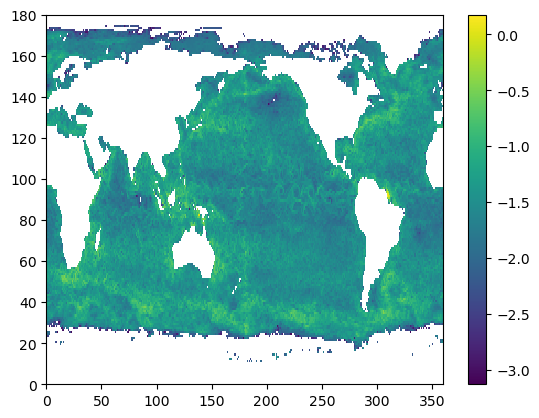

In [7]:
%%time

plt.figure()
plt.pcolormesh(np.log10(fsle_std.isel(time=0)))
plt.colorbar()


### Save to netcdf

In [8]:
%%time

print("/g/data/es60/observations/AVISO_FSLE_std_1x1deg_%s.nc"%(year))
fsle_std.to_netcdf("/g/data/es60/observations/AVISO_FSLE_std_1x1deg_%s.nc"%(year))


/g/data/es60/observations/AVISO_FSLE_std_1x1deg_2011.nc
CPU times: user 175 ms, sys: 176 ms, total: 351 ms
Wall time: 1.8 s


## Do all remaining years

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for yyyy in np.arange(2009, 2024,1):
    print("Doing year %s"%(yyyy))
    
    # Load
    ds = xr.open_mfdataset(
        './%s/dt_global_allsat_madt_fsle_%s*.nc'%(yyyy,yyyy),
        combine='by_coords',
        parallel=True,
        chunks={'time': 1}
    )
    
    ds = ds.compute()
    
    # Create bin edges: from -179.5 to 180.5 by 1°
    lon_bins = np.arange(0, 361, 1)
    lat_bins = np.arange(-90, 91, 1)
    
    # Use pandas.cut on the 1D coordinate arrays
    lon_labels = lon_bins[:-1] + 0.5
    lat_labels = lat_bins[:-1] + 0.5
    
    # Apply binning to lon and lat values
    lon_binned = pd.cut(ds['lon'].values, bins=lon_bins, labels=lon_labels)
    lat_binned = pd.cut(ds['lat'].values, bins=lat_bins, labels=lat_labels)
    
    # Create new coordinates
    ds = ds.assign_coords(
        lon_bin=xr.DataArray(lon_binned, coords={"lon": ds['lon']}, dims="lon"),
        lat_bin=xr.DataArray(lat_binned, coords={"lat": ds['lat']}, dims="lat")
    )
    
    lat_grouped = ds['fsle_max'].groupby('lat_bin')
    fsle_std = lat_grouped.map(lambda g: g.groupby('lon_bin').std(dim=('lat', 'lon')))
    
    # Save
    fsle_std.to_netcdf("/g/data/es60/observations/AVISO_FSLE_std_1x1deg_%s.nc"%(yyyy))




Doing year 2009
[########################################] | 100% Completed | 30.07 s
[########################################] | 100% Completed | 28m 11s
